# ELP.09 - Octopamine Side Learning Y-Maze
<hr style="border:2px solid gray"> </hr>

**Author:** Henrique Galante | henrique.galante@ur.de

**Last Updated:** April 2022

This supplement provides the entire R script and output of the statistical analysis performed and figures produced, in their original form. It is presented in the spirit of open and transparent science, but has not been carefully curated.

## Data handling
<hr style="border:0.5px solid gray"> </hr>

### Load packages

In [1]:
require(reshape2) # For data handling
require(lme4) # Linear mixed-effects models
require(DHARMa) # Evaluate model fit
require(car) # Anova() function [instead of base R anova()]
require(emmeans) # Post-hoc analysis on the model

Loading required package: reshape2

Loading required package: lme4

Loading required package: Matrix

Loading required package: DHARMa

Warning message:
“package ‘DHARMa’ was built under R version 4.1.2”
This is DHARMa 0.4.5. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')

Loading required package: car

Loading required package: carData

Warning message:
“package ‘carData’ was built under R version 4.1.2”
Loading required package: emmeans

Warning message:
“package ‘emmeans’ was built under R version 4.1.2”


### Clean-up

In [2]:
rm(list = ls()) # Remove variables/objects
graphics.off() # Close any open graphics

### Load data

In [3]:
ELP_09 = read.csv("./Data/ELP_09_octopamine_side_learning_Y_maze.csv", header = TRUE, stringsAsFactors = FALSE, sep = ";")
head(ELP_09, n = 1) # Check if data was imported correctly

,Collection_Date,Time_Collection,Experimentor,Temperature,Colony_Origin,Starvation_Period,Donor_Colony,Recipient_Colony,Ant_ID,Visit,⋯,Initial_Decision,Final_Decision,Number_Relocations,In_Duration,Drinking_Duration,Out_Duration,Bridge_Nest_Duration,Total_Duration_Minutes,Trophallaxis,Full
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>
1,04.04.22,11:20,Laura Neubauer,"24,9",5th November - Spain / 9th April - Spain,4-days,32,7,1,2,⋯,L,L,0,19,56,17,482,"9,6",Yes,No


### Column descriptions

| Column Name            | Description |
| ---:                   | :---        |
| **Collection_Date**        | Testing date       |
| **Time_Collection**        | Starting time of data collection        |
| **Experimentor**           | Name of the person collecting the data       |
| **Temperature**            | Room temperature at start of data collection        |
| **Colony_Origin**          | Country of origin and time of arrival to the lab of the colonies used       |
| **Starvation_Period**      | How long were the ants deprived of food for        |
| **Donor_Colony**           | ID of the colony where the ant originated from (naive colony)       |
| **Recipient_Colony**       | ID of the colony the ant was placed in (non-naive colony)        |
| **Ant_ID**                 | ID of the ant used       |
| **Visit**                  | Visit number        |
| **Solution**               | Which solution was each ant tested with       |
| **Reward_Side**            | In which side of the Y-maze was the solution placed        |
| **Time_Since_Marking**     | How long was the ant in the nest for between marking (visit 1) and visit 2       |
| **Initial_Decision**       | Which side of the Y-maze the ant first crossed a 2cm line        |
| **Final_Decision**         | Which side of the Y-maze the ant first touched the solution drop       |
| **Number_Relocations**     | How many times was the ant relocated during a visit due to escaping or falling on water        |
| **In_Duration**            | How long in seconds did the ant take to reach the drop of solution       |
| **Drinking_Duration**      | How long in seconds did the ant take feeding on the drop of solution        |
| **Out_Duration**           | How long in seconds did the ant take to return to the bridge       |
| **Bridge_Nest_Duration**   | How long in seconds did the ant take to return to the colony       |
| **Total_Duration_Minutes** | How long in minutes did the ant take in the whole trip       |
| **Trophallaxis**           | Was the ant seen doing trophallaxis after returning to the colony from the visit        |
| **Full**                   | Was the ant visibly full (expanded gaster) at the beggining of the visit       | 

### Unblind the solutions

In [4]:
ELP_09$Solution = ifelse(ELP_09$Solution == "B", "0.01mM Octopamine", "Control")

### Get a binary (right/wrong) initial and final decision and check how many ants switched between their initial and final decision

In [6]:
ELP_09$Initial_Decision_Binary = ifelse(ELP_09$Initial_Decision == ELP_09$Reward_Side, 1, 0)
ELP_09$Final_Decision_Binary = ifelse(ELP_09$Final_Decision == ELP_09$Reward_Side, 1, 0)
ELP_09$Switched_Decision_Binary = ifelse(ELP_09$Initial_Decision_Binary == ELP_09$Final_Decision_Binary, 0, 1)
paste0("Ants switched their final decision in ", round(sum(ELP_09$Switched_Decision_Binary) / nrow(ELP_09) * 100, 0), "% of the visits!")

[1] "Ants switched their final decision in 3% of the visits!"

### Sample size per solution per side

In [7]:
table(ELP_09$Solution, ELP_09$Reward_Side) / 4

                   
                     L  R
  0.01mM Octopamine 16 16
  Control           16 16

### Ensure that the Bridge_Nest_Duration for visit 2 is the same as the time since marking for visit 2

In [8]:
for (i in 1:nrow(ELP_09)) {
  if (ELP_09$Visit[i] == "2" & !is.na(ELP_09$Bridge_Nest_Duration[i])) {
    if (ELP_09$Bridge_Nest_Duration[i] != ELP_09$Time_Since_Marking[i]) {
      print(paste0("Warning: Row ", i, " was changed from ", ELP_09$Bridge_Nest_Duration[i], "s to ", ELP_09$Time_Since_Marking[i], "s!"))
      ELP_09$Bridge_Nest_Duration[i] = ELP_09$Time_Since_Marking[i]
    }
  }
  else if (ELP_09$Visit[i] == "2" & is.na(ELP_09$Bridge_Nest_Duration[i])) {
    ELP_09$Bridge_Nest_Duration[i] = ELP_09$Time_Since_Marking[i]
    print(paste0("Warning: Row ", i, " was changed and Bridge_Nest_Duration was NA!"))
  }
}

[1] "Warning: Row 177 was changed from 12s to 3540s!"


### Create time intervals to group replicates based on time since marking

In [11]:
for (i in 1:nrow(ELP_09)) {
  if (ELP_09$Time_Since_Marking[i] <= 1800) {
    ELP_09$TSM_Bin[i] = "0-30"
  }
  else if (ELP_09$Time_Since_Marking[i] > 1800 & ELP_09$Time_Since_Marking[i] <= 3600) {
    ELP_09$TSM_Bin[i] = "30-60"
  }
  else {
    print("Warning: Undefined bins!")
  }
}

### Sample size per solution per time bin and per side

In [12]:
table(ELP_09$Solution, ELP_09$TSM_Bin, ELP_09$Reward_Side) / 4

, ,  = L

                   
                    0-30 30-60
  0.01mM Octopamine    8     8
  Control              8     8

, ,  = R

                   
                    0-30 30-60
  0.01mM Octopamine    8     8
  Control              8     8


### Ensure relevant columns are factors

In [13]:
ELP_09$Collection_Date = as.factor(ELP_09$Collection_Date)
ELP_09$Time_Collection = as.factor(ELP_09$Time_Collection)
ELP_09$Experimentor = as.factor(ELP_09$Experimentor)
ELP_09$Starvation_Period = as.factor(ELP_09$Starvation_Period)
ELP_09$Donor_Colony = as.factor(ELP_09$Donor_Colony)
ELP_09$Recipient_Colony = as.factor(ELP_09$Recipient_Colony)

ELP_09$Visit = as.factor(ELP_09$Visit)
ELP_09$Solution = as.factor(ELP_09$Solution)
ELP_09$Solution = relevel(ELP_09$Solution, "Control")
ELP_09$Reward_Side = as.factor(ELP_09$Reward_Side)
ELP_09$TSM_Bin = as.factor(ELP_09$TSM_Bin)

ELP_09$Initial_Decision_Binary = as.factor(ELP_09$Initial_Decision_Binary)
ELP_09$Final_Decision_Binary = as.factor(ELP_09$Final_Decision_Binary)

## Data analysis
<hr style="border:0.5px solid gray"> </hr>

### Preliminary question
#### Do initial and final choices differ significantly?

In [14]:
initial_final_diff = melt(ELP_09, measure.vars = c("Initial_Decision_Binary", "Final_Decision_Binary"))
initial_final_diff$value = as.factor(initial_final_diff$value)
head(initial_final_diff, n = 1) # Check if data was imported correctly

,Collection_Date,Time_Collection,Experimentor,Temperature,Colony_Origin,Starvation_Period,Donor_Colony,Recipient_Colony,Ant_ID,Visit,⋯,Drinking_Duration,Out_Duration,Bridge_Nest_Duration,Total_Duration_Minutes,Trophallaxis,Full,Switched_Decision_Binary,TSM_Bin,variable,value
,<fct>,<fct>,<fct>,<chr>,<chr>,<fct>,<fct>,<fct>,<int>,<fct>,⋯,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<fct>,<fct>,<fct>
1,04.04.22,11:20,Laura Neubauer,"24,9",5th November - Spain / 9th April - Spain,4-days,32,7,1,2,⋯,56,17,482,"9,6",Yes,No,0,0-30,Initial_Decision_Binary,1


In [15]:
diff_model = glmer(value ~ variable + (1|Starvation_Period) + (1|Experimentor/Collection_Date), data = initial_final_diff,family = binomial, glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))
Anova(diff_model)

boundary (singular) fit: see ?isSingular



,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
variable,0.4349555,1,0.5095673


In [16]:
e = emmeans(diff_model, ~variable, type = "response")
pairs(e)

 contrast                                        odds.ratio    SE  df null
 Initial_Decision_Binary / Final_Decision_Binary      0.866 0.189 Inf    1
 z.ratio p.value
  -0.660  0.5096

Tests are performed on the log odds ratio scale 

There is no siginificant difference between inital and final decision, hence we will only use final decision for further analysis as this is a better measure of learning considering it allows the individuals to correct a potentially wrong initial choice (which could be attributed to exploration)
### Modelling
Instead of building a super complicated model with all possible interactions, we will consider two-way interactions (three-way+ interactions are almost impossible to interpret biologically) exclusively: how do pairs of variables affect each other?

y ~ (a + b + c)^2 gets all two way combinations of the variables in the brackets, hence being a faster way of getting this model:

y ~ a + b + c + a:b + a:c + b:c

We start with the maximal model below and simplify gradually by removing terms that explain little to no variation in this way obtaining a simpler, equally, if not more, meaningful.

In [32]:
mod1 = glmer(Final_Decision_Binary ~ (Reward_Side + Solution + TSM_Bin + Visit)^2  +
               (1|Starvation_Period) + (1|Collection_Date), 
             data = ELP_09, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

#### Is the maximal model a good fit to the data?

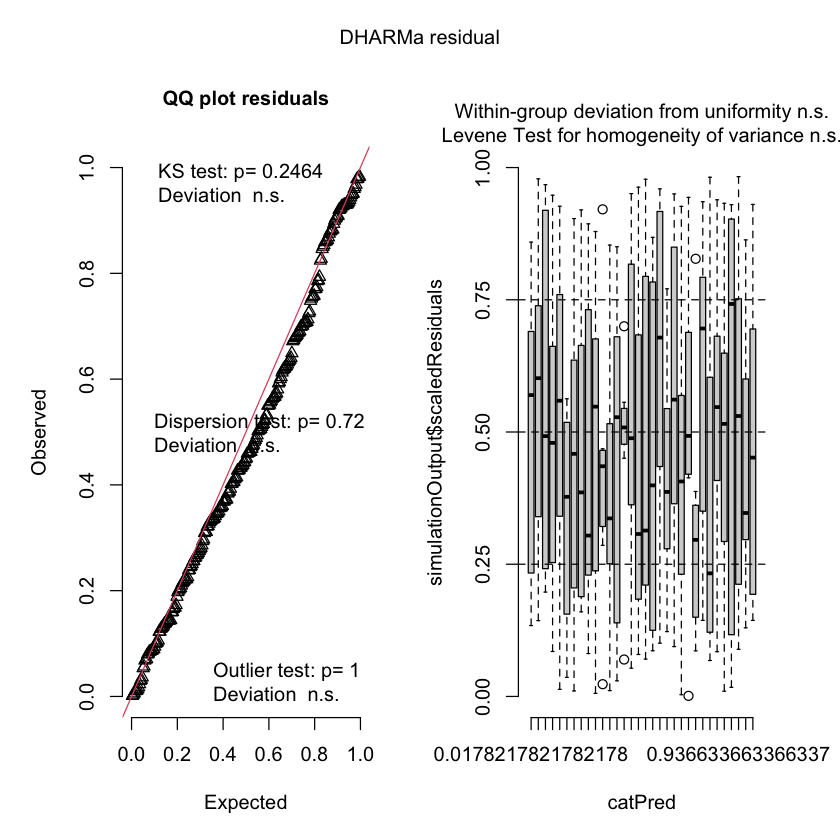

In [33]:
simres = simulateResiduals(mod1)
plot(simres, asFactor = T)

Yes, the diagnostic plots indicate the model is good
#### Model simplification

In [34]:
summary(mod1)
Anova(mod1)
drop.scope(mod1)


Correlation matrix not shown by default, as p = 19 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
Final_Decision_Binary ~ (Reward_Side + Solution + TSM_Bin + Visit)^2 +  
    (1 | Starvation_Period) + (1 | Collection_Date)
   Data: ELP_09
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   271.6    346.0   -114.8    229.6      235 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6519  0.1835  0.3514  0.5122  1.3222 

Random effects:
 Groups            Name        Variance Std.Dev.
 Collection_Date   (Intercept) 0.24019  0.4901  
 Starvation_Period (Intercept) 0.07934  0.2817  
Number of obs: 256, groups:  Collection_Date, 4; Starvation_Period, 2

Fixed effects:
                                       Estimate Std. Error z value Pr(>|z|)  
(Intercept)                             1.98914    0.88122   2.257   0.0240 *
Reward_SideR                           -0.12353  

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,10.56387267,1,0.001153193
Solution,1.15891187,1,0.281691324
TSM_Bin,0.03619273,1,0.849118043
Visit,0.34208270,3,0.951928925
Reward_Side:Solution,0.10721669,1,0.743335423
Reward_Side:TSM_Bin,0.01039160,1,0.918804921
Reward_Side:Visit,3.11122807,3,0.374791890
Solution:TSM_Bin,2.74649039,1,0.097468159
Solution:Visit,1.10014677,3,0.777038652


[1] "Reward_Side:Solution" "Reward_Side:TSM_Bin"  "Reward_Side:Visit"   
[4] "Solution:TSM_Bin"     "Solution:Visit"       "TSM_Bin:Visit"

In [35]:
mod2 = update(mod1, . ~ . - Reward_Side:TSM_Bin)
anova(mod1, mod2)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod2,20,269.5884,340.4920,-114.7942,229.5884,NA,NA,NA
mod1,21,271.5781,346.0269,-114.7891,229.5781,0.01028705,1,0.919213


mod1 is not significantly better than mod2 so we will keep mod2

In [36]:
summary(mod2)
Anova(mod2)
drop.scope(mod2)


Correlation matrix not shown by default, as p = 18 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Decision_Binary ~ Reward_Side + Solution + TSM_Bin + Visit +  
    (1 | Starvation_Period) + (1 | Collection_Date) + Reward_Side:Solution +  
    Reward_Side:Visit + Solution:TSM_Bin + Solution:Visit + TSM_Bin:Visit
   Data: ELP_09
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   269.6    340.5   -114.8    229.6      236 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6784  0.1811  0.3481  0.5144  1.3247 

Random effects:
 Groups            Name        Variance Std.Dev.
 Collection_Date   (Intercept) 0.23598  0.4858  
 Starvation_Period (Intercept) 0.07868  0.2805  
Number of obs: 256, groups:  Collection_Date, 4; Starvation_Period, 2

Fixed effects:
                                       Estimate Std. Error z value Pr(>|z|)  
(Intercept)                    

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,10.56850343,1,0.001150308
Solution,1.15590027,1,0.282317414
TSM_Bin,0.03494956,1,0.851701395
Visit,0.34028015,3,0.952283089
Reward_Side:Solution,0.09780786,1,0.754476316
Reward_Side:Visit,3.13333988,3,0.371520174
Solution:TSM_Bin,2.77910907,1,0.095501281
Solution:Visit,1.10785952,3,0.775177111
TSM_Bin:Visit,4.12165527,3,0.248623667


[1] "Reward_Side:Solution" "Reward_Side:Visit"    "Solution:TSM_Bin"    
[4] "Solution:Visit"       "TSM_Bin:Visit"

In [37]:
mod3 = update(mod2, . ~ . - Reward_Side:Solution)
anova(mod2, mod3)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod3,19,267.6850,335.0433,-114.8425,229.6850,NA,NA,NA
mod2,20,269.5884,340.4920,-114.7942,229.5884,0.09655302,1,0.756006


mod2 is not significantly better than mod3 so we will keep mod3

In [38]:
summary(mod3)
Anova(mod3)
drop.scope(mod3)


Correlation matrix not shown by default, as p = 17 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Decision_Binary ~ Reward_Side + Solution + TSM_Bin + Visit +  
    (1 | Starvation_Period) + (1 | Collection_Date) + Reward_Side:Visit +  
    Solution:TSM_Bin + Solution:Visit + TSM_Bin:Visit
   Data: ELP_09
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   267.7    335.0   -114.8    229.7      237 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7527  0.1821  0.3520  0.5097  1.2936 

Random effects:
 Groups            Name        Variance Std.Dev.
 Collection_Date   (Intercept) 0.21897  0.4679  
 Starvation_Period (Intercept) 0.07826  0.2797  
Number of obs: 256, groups:  Collection_Date, 4; Starvation_Period, 2

Fixed effects:
                                       Estimate Std. Error z value Pr(>|z|)  
(Intercept)                              2.0831     0.

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,10.56405339,1,0.001153081
Solution,1.15981241,1,0.281504448
TSM_Bin,0.03030224,1,0.861806209
Visit,0.32611574,3,0.955044264
Reward_Side:Visit,3.22288420,3,0.358520744
Solution:TSM_Bin,2.83522365,1,0.092217961
Solution:Visit,1.20550429,3,0.751684461
TSM_Bin:Visit,4.11418227,3,0.249395546


[1] "Reward_Side:Visit" "Solution:TSM_Bin"  "Solution:Visit"   
[4] "TSM_Bin:Visit"

In [39]:
mod4 = update(mod3, . ~ . - Solution:Visit)
anova(mod3, mod4)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod4,16,262.9021,319.6249,-115.4510,230.9021,NA,NA,NA
mod3,19,267.6850,335.0433,-114.8425,229.6850,1.217104,3,0.7489051


mod3 is not significantly better than mod4 so we will keep mod4

In [40]:
summary(mod4)
Anova(mod4)
drop.scope(mod4)


Correlation matrix not shown by default, as p = 14 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Decision_Binary ~ Reward_Side + Solution + TSM_Bin + Visit +  
    (1 | Starvation_Period) + (1 | Collection_Date) + Reward_Side:Visit +  
    Solution:TSM_Bin + TSM_Bin:Visit
   Data: ELP_09
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   262.9    319.6   -115.5    230.9      240 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1832  0.1797  0.3481  0.5134  1.3700 

Random effects:
 Groups            Name        Variance Std.Dev.
 Collection_Date   (Intercept) 0.20592  0.4538  
 Starvation_Period (Intercept) 0.07662  0.2768  
Number of obs: 256, groups:  Collection_Date, 4; Starvation_Period, 2

Fixed effects:
                                       Estimate Std. Error z value Pr(>|z|)   
(Intercept)                              2.3232     0.7518   3.090   0

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,10.6154863,1,0.001121445
Solution,1.2085249,1,0.271624463
TSM_Bin,0.0310207,1,0.860194220
Visit,0.3473531,3,0.950889888
Reward_Side:Visit,3.0543520,3,0.383320839
Solution:TSM_Bin,2.5234328,1,0.112166171
TSM_Bin:Visit,3.7780917,3,0.286444735


[1] "Reward_Side:Visit" "Solution:TSM_Bin"  "TSM_Bin:Visit"

In [41]:
mod5 = update(mod4, . ~ . - Reward_Side:Visit)
anova(mod4, mod5)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod5,13,260.0125,306.0998,-117.0062,234.0125,NA,NA,NA
mod4,16,262.9021,319.6249,-115.4510,230.9021,3.110377,3,0.3749183


mod4 is not significantly better than mod5 so we will keep mod5

In [42]:
summary(mod5)
Anova(mod5)
drop.scope(mod5)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Decision_Binary ~ Reward_Side + Solution + TSM_Bin + Visit +  
    (1 | Starvation_Period) + (1 | Collection_Date) + Solution:TSM_Bin +  
    TSM_Bin:Visit
   Data: ELP_09
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   260.0    306.1   -117.0    234.0      243 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5541  0.2012  0.3480  0.5337  1.3049 

Random effects:
 Groups            Name        Variance Std.Dev.
 Collection_Date   (Intercept) 0.19608  0.4428  
 Starvation_Period (Intercept) 0.07384  0.2717  
Number of obs: 256, groups:  Collection_Date, 4; Starvation_Period, 2

Fixed effects:
                                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)                              2.9063     0.7025   4.137 3.52e-05 ***
Reward_Si

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,12.08630222,1,0.0005079361
Solution,1.19694015,1,0.2739341028
TSM_Bin,0.02890483,1,0.8649989711
Visit,0.48758522,3,0.9216102952
Solution:TSM_Bin,2.52116172,1,0.1123278052
TSM_Bin:Visit,3.64165884,3,0.3028488306


[1] "Reward_Side"      "Solution:TSM_Bin" "TSM_Bin:Visit"

In [43]:
mod6 = update(mod5, . ~ . - TSM_Bin:Visit)
anova(mod5, mod6)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod6,10,257.8126,293.2643,-118.9063,237.8126,NA,NA,NA
mod5,13,260.0125,306.0998,-117.0062,234.0125,3.800093,3,0.2838753


mod5 is not significantly better than mod6 so we will keep mod6

In [44]:
summary(mod6)
Anova(mod6)
drop.scope(mod6)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Decision_Binary ~ Reward_Side + Solution + TSM_Bin + Visit +  
    (1 | Starvation_Period) + (1 | Collection_Date) + Solution:TSM_Bin
   Data: ELP_09
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   257.8    293.3   -118.9    237.8      246 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3542  0.2226  0.3527  0.5504  1.1290 

Random effects:
 Groups            Name        Variance Std.Dev.
 Collection_Date   (Intercept) 0.18668  0.4321  
 Starvation_Period (Intercept) 0.07095  0.2664  
Number of obs: 256, groups:  Collection_Date, 4; Starvation_Period, 2

Fixed effects:
                                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)                              2.8480     0.6241   4.564 5.03e-06 ***
Reward_SideR                   

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,11.9369673,1,0.0005503099
Solution,1.1854830,1,0.2762425823
TSM_Bin,0.0211024,1,0.8845003312
Visit,0.5086390,3,0.9169894117
Solution:TSM_Bin,2.4855615,1,0.1148953400


[1] "Reward_Side"      "Visit"            "Solution:TSM_Bin"

In [45]:
mod7 = update(mod6, . ~ . - Solution:TSM_Bin)
anova(mod6, mod7)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod7,9,258.3148,290.2214,-120.1574,240.3148,NA,NA,NA
mod6,10,257.8126,293.2643,-118.9063,237.8126,2.502208,1,0.1136868


mod6 is not significantly better than mod7 so we will keep mod7

In [46]:
summary(mod7)
Anova(mod7)
drop.scope(mod7)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Decision_Binary ~ Reward_Side + Solution + TSM_Bin + Visit +  
    (1 | Starvation_Period) + (1 | Collection_Date)
   Data: ELP_09
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   258.3    290.2   -120.2    240.3      247 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7652  0.2261  0.3636  0.5597  1.0193 

Random effects:
 Groups            Name        Variance Std.Dev.
 Collection_Date   (Intercept) 0.21596  0.4647  
 Starvation_Period (Intercept) 0.07824  0.2797  
Number of obs: 256, groups:  Collection_Date, 4; Starvation_Period, 2

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)                2.54619    0.58749   4.334 1.46e-05 ***
Reward_SideR              -1.22246    0.35363  -3.457 0.000546 ***
Solution0

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,11.95004498,1,0.0005464606
Solution,1.29030053,1,0.2559925739
TSM_Bin,0.02471059,1,0.8750903517
Visit,0.50343718,3,0.9181356322


[1] "Reward_Side" "Solution"    "TSM_Bin"     "Visit"

Worth to mention from the model summary a significant decrease in success rate on the right side of the Y-maze and a slight, yet not significant, decrease in success rate under the influence of 0.01mM octopamine. Both Starvation_Period and Collection_Date explain a small amount of variance in the data.

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod7,9,258.3148,290.2214,-120.1574,240.3148,NA,NA,NA
mod1,21,271.5781,346.0269,-114.7891,229.5781,10.73662,12,0.5516149


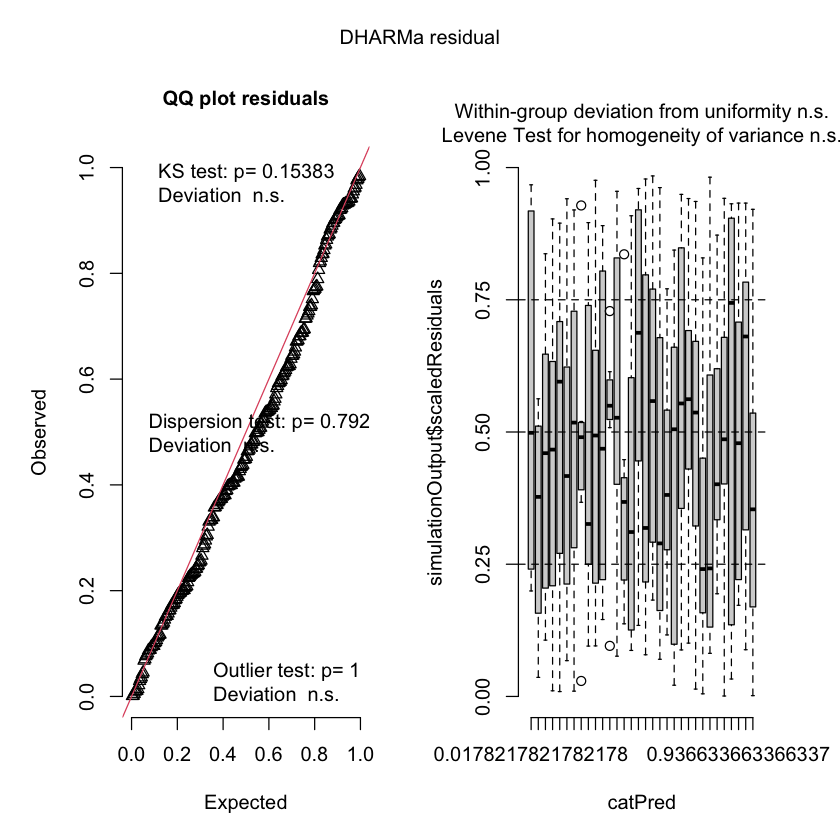

In [47]:
anova(mod1, mod7)
simres = simulateResiduals(mod6)
plot(simres, asFactor = T)

mod1 is not significantly better than mod6 so we will keep mod7 - the diagnostic plots suggest mod7 is still a good fit.

#### Model interpretation
There is an effect of reward side:

In [49]:
meanobj = emmeans(mod7, ~Reward_Side, type = "response")
pairs(meanobj, adjust = "bonferroni")

 contrast odds.ratio  SE  df null z.ratio p.value
 L / R           3.4 1.2 Inf    1   3.457  0.0005

Results are averaged over the levels of: Solution, TSM_Bin, Visit 
Tests are performed on the log odds ratio scale 

Ants tend to chose the left side of the Y-maze more often than the right side.

In [50]:
meanobj = emmeans(mod7, ~TSM_Bin * Visit, type = "response")
test(meanobj)

,TSM_Bin,Visit,prob,SE,df,null,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0-30,2,0.8517040,0.06329740,Inf,0.5,3.488035,0.0004865841
2,30-60,2,0.8450512,0.06455814,Inf,0.5,3.440515,0.0005806075
3,0-30,3,0.8372860,0.06732895,Inf,0.5,3.314793,0.0009171116
4,30-60,3,0.8301153,0.06855009,Inf,0.5,3.263695,0.0010996953
5,0-30,4,0.8075647,0.07502659,Inf,0.5,2.970816,0.0029700991
6,30-60,4,0.7993981,0.07613171,Inf,0.5,2.912120,0.0035898487
7,0-30,5,0.8372860,0.06732893,Inf,0.5,3.314793,0.0009171091
8,30-60,5,0.8301153,0.06855011,Inf,0.5,3.263694,0.0010996992


All ants independent of time since marking had a success rate significantly different from chance (50%).

In [51]:
meanobj = emmeans(mod7, ~Solution, type = "response")
test(meanobj)
pairs(meanobj, adjust = "bonferroni")

,Solution,prob,SE,df,null,z.ratio,p.value
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Control,0.8551682,0.05067403,Inf,0.5,4.340160,1.423787e-05
2,0.01mM Octopamine,0.8024799,0.06202008,Inf,0.5,3.582777,3.399608e-04


 contrast                    odds.ratio    SE  df null z.ratio p.value
 Control / 0.01mM Octopamine       1.45 0.478 Inf    1   1.136  0.2560

Results are averaged over the levels of: Reward_Side, TSM_Bin, Visit 
Tests are performed on the log odds ratio scale 

There was **no significant difference between control and 0.1mM octopamine** solutions suggesting octopamine has little to no effect on the ants ability to associate a reward with a side of the Y-maze.

In [52]:
meanobj = emmeans(mod7, ~1, type = "response")
test(meanobj)

,1,prob,SE,df,null,z.ratio,p.value
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,overall,0.8304466,0.05138242,Inf,0.5,4.353833,1.337777e-05


Overall, the ants successfully associated the presence of a reward with a side of the Y-maze with a **83%** success rate, a percentage significantly different from chance level (50%).

In [32]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] emmeans_1.7.3  car_3.0-12     carData_3.0-5  DHARMa_0.4.5   lme4_1.1-27.1 
[6] Matrix_1.3-3   reshape2_1.4.4

loaded via a namespace (and not attached):
 [1] gap_1.2.3-1         Rcpp_1.0.7          pillar_1.6.3       
 [4] compiler_4.1.0      nloptr_1.2.2.2      plyr_1.8.7         
 [7] base64enc_0.1-3     tools_4.1.0         boot_1.3-28        
[10] digest_0.6.28       uuid_0.1-4          jsonlite_1.7.2     
[13] evaluate_0.14       lifecycle_1.0.1     nlme_3.1-152       
[16] lattice_0.20-44     rlang_0.4.11        IRdisplay_1.0      
